# AppStream Demo

AppStream 2.0 is an AWS service that allows streaming of desktop applications to users. In this demo, I will show how to stream Sleap (a pose estimation package) to users. 

<div class="alert alert-block alert-info">
<b>Workflow:</b> Create an Image using image builder → Create a Fleet using the Image → Create a Stack associated with the Fleet → Create Users → Assign Stack to the users
</div>


## Terminology

- **Streaming / Fleet instance**: An EC2 instance available to a single user for application streaming. 
- **Image**: A snapshot of an EC2 instance consisting of applications that can be streamed to users, as well as default system and app settings.
- **Fleet**: Consists of multiple fleet instances / streaming instances ran by multiple users. 
- **Stack**: Contains an associated fleet, user access policies, and storage configurations. 
 
    
The streaming instances are never created directly in the console. Instead, they are managed through a stack, which has an associated fleet. This fleet is created based on a specific image, so all streaming instances launched from this stack will run the applications specified in that image.


- **Image builder**: An EC2 instance used to create images. An image builder will be launched from an existing image, applications will be installed in the image builder, and a new image containing the installed applications can be created. 

- **Instance families**: When launching an image builder or creating a fleet, you would need to specify an instance type that dictates the hardware that will be used when launching instances. There are multiple instance families which offer instance types that differ in compute, memory, and GPU capabilities. 



## Create an Image with Sleap Installed

### Image Builder Users



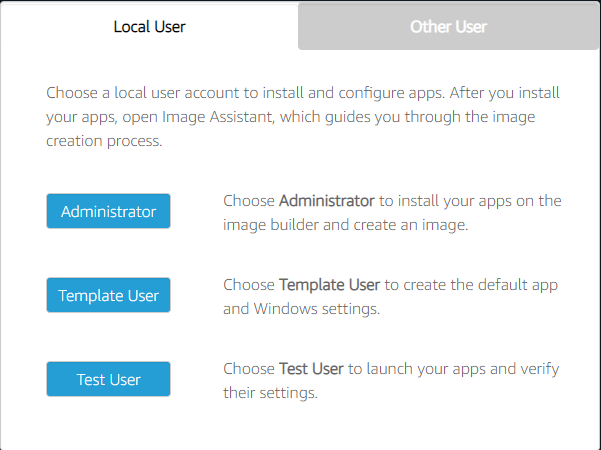

### Steps to follow 

**1. Launch Image builder with GPU support**

AWS provides some base images to start from. Since we want to install Sleap for this demo, we would like to pick an instance type that provides NVIDIA GPU support. However, these resources are limited under a quota, so we had to request for a quota increase from AWS. We will be using the latest Graphics G4 Instance family which provides NVIDIA GPU support, specifically the `stream.graphics.g4dn.xlarge` instance type which provides the lowest amount of resource (e.g. vCPU, memory). Default internet access is enabled to add Internet access to the image builder's streaming instance.

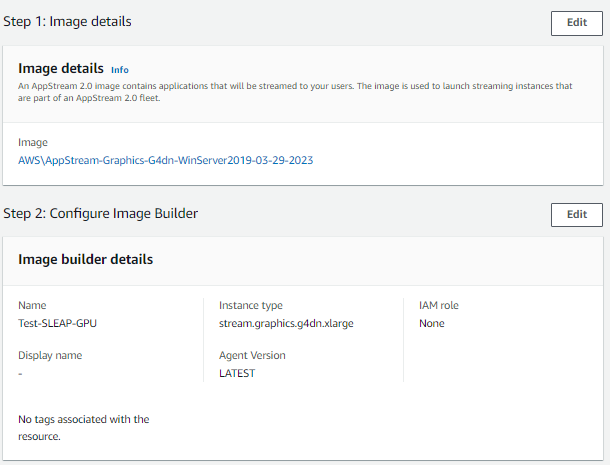

**2. (Admin user) Install Apps**

Open Firefox and download installers for the applications you would like. Launch the installers and follows the instructions. 

**Special instructions for installing Conda**: When launching the Miniconda installer, do NOT use the default install location! Instead, create a new folder called `miniconda3` directly under `:C\` and install Miniconda there. 

<div class="alert alert-block alert-warning">
<b>Beware:</b> Do not install applications under the `C:\Users` folder because other users (e.g. Template and Test users) will not have permissions to access them. This won't be a common issue since typical apps are all installed under `C:\Program Files` or `C:\Program Files (x86)`. <b>Anything that is stored directly under `C:\` should be completed as an Admin User, anything that is stored under `C:\Users\` folder should be completed as a Template User. </b>
</div>

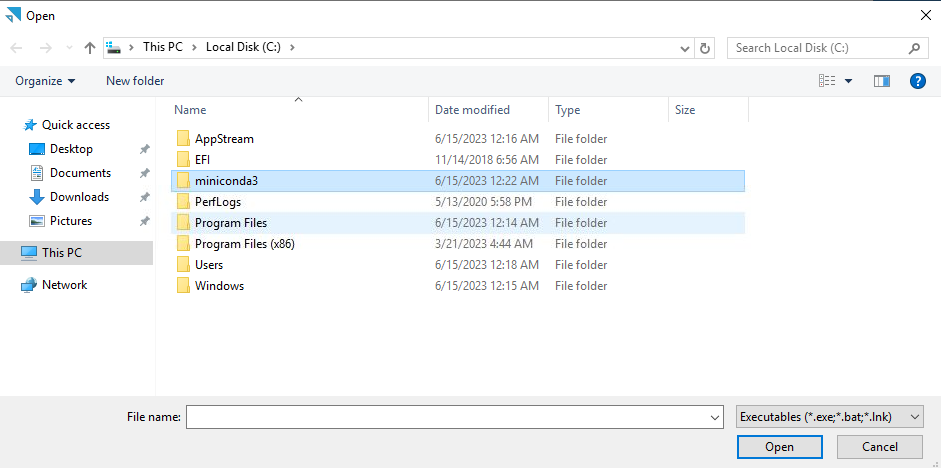

**3. (Admin User) Add App to Image**

Open Image Assistance and click Add App. For typical desktop apps like Chrome, GitBash, you would select the executable file (typically located under `:C\Program Files`, or click the Desktop shorcut icon), and the configurations would be autocompleted. However, it is trickier for conda as there is no single executable file that would launch the Anaconda Prompt automatically. I managed to find a workaround and here are the configurations that should be entered to successfully add it as an application. Essentially, it launches the Windows default Command Prompt app and runs some conda executable files to setup conda. 

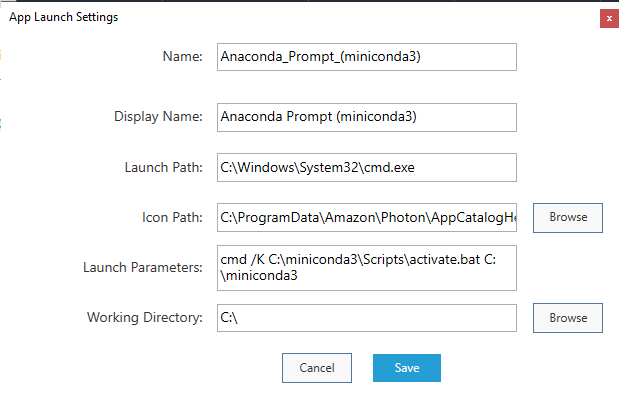

Here were the steps that I went through to obtain the workaround configurations. First, turn on show hidden files in File Explorer. Then click Add app in Image Assistance, navigate to the Start Menu shortcut of Anaconda Prompt and select the shortcut. (You may Google how to show hidden files and where the Start Menu shortcut is located if needed.) The following configurations would be generated automatically. Then, change the Launch Parameters and Working directory to match the figure above. 

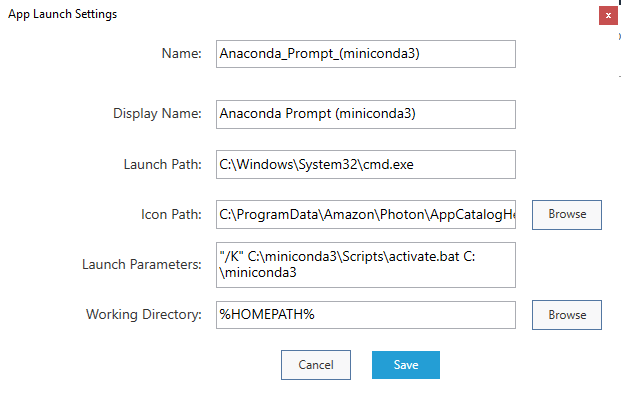

**4. (Admin User) Install Packages**

Open the Anaconda Prompt from the start menu, and start installing desired packages. 

**Sleap:** This pose estimation package is installed for the purpose of this summer project. For more detailed instructions on installing Sleap, visit the [Sleap Demo notebook](./Sleap-Demo.ipynb).

    conda update conda -y
    conda create -n sleap -c sleap -c nvidia -c conda-forge -y sleap=1.3.0
    conda env list

**Boto3:** This AWS SDK package for Python may be useful for users who would like to access AWS services. 

    pip install boto3

**5. (Template User) Setup default configurations for all users**

You may switch to Template user mode to create default app settings and Windows settings that would appply to all users. As a result, users who launch instances from the resulting image won't need to configure these settings themselves and can get started with the applications quickly. Default settings that you can create and configure include:

- Application preferences, including a browser home page, toolbar customizations, and security settings.
- Application data settings, including browser bookmarks and connection profiles.
- Windows experience settings, including displaying file name extensions and hidden folders.

**Set environment variable:** For this demo, we set a default environment variable for the AWS profile created by Appstream. This would simplify the work that the users have to do when accessing AWS services from their fleet instances because they wouldn't have to worry about entering a profile name everytime. 

    setx AWS_PROFILE "appstream_machine_role"

Once completed, click switch back to Admin user in Image Assistance. 

**6. (Admin User) Save default configureations**

Click Save Settings so that all configurations that were setup in Template User will be saved and copied to Test user. 

*P.S. If the packages were installed while in Template User mode, they would be stored under `C:\Users\DefaultProfileUser` and the save would be unsuccessful, presumably due to the lack of read / write permissions in User Data folders. Hence, packages such as SLEAP should be installed in Admin user mode along with other apps.*

**7. (Test User) Test Conda App**

Click next and switch to Test user mode to check if the app is running properly. For this demo, we first checked that there is a sleap environment that can be activated, and check that the sleap GUI can be opened properly. 

```
conda env list
conda activate sleap
sleap-label
```

Then we ran `set | findstr 'AWS_PROFILE'` to check that the default AWS profile was set correctly.
    
Finally, we typed `s3fs` to check that the alias works as expected (i.e. giving a `missing BUCKET argument` error)

**8. (Admin User) Optimize app launch**

This is an automated process to perform optimizations to reduce the time that it takes for the application to launch for the first time on a new fleet instance. There isn't much to do if you are using the AWS console for this step. (If using AWS CLI, you would have to specify which files to optimize for. )

Image Assistance will automatically launch the apps one by one. After each app starts, provide any required input and perform the first run experience for the app (E.g. a web browser may prompt you to import settings before it is completely up and running). Image Assistance will automatically detect the files that should be optimized. 

For this demo, I let the Image Assistance launch Anaconda Prompt and verified that the sleap GUI can be launched successfully before hitting Continue. 

**9. (Admin User) Configure image details**

Complete the details for the resulting image (e.g. name, description), then click `Disconnect and Create Image`. The session will disconnect and may prompt you to retry the connection, but you can close the browser tab now. The image is being created and the image builder stats will appear as Snapshotting in the console. Once the snapshot is complete, the image builder will be stopped, and the demo image is ready for use. 

## Create Stack from Image

**1. Create fleet from Demo Image** (remember to choose the same instance type)

When creating a fleet, you can choose Applications view or Desktop view. The only difference is that users can only open windows of the apps in App view, whereas in Desktop view, the users can additionally choose to see the standard desktop available on the OS. 

There are also different fleet types. On Demand costs less when fleet is running but no user streaming instances, but takes more time (~2min) to launch each streaming instance. 

This demo creates a stack using the Demo Image we created earlier, with App view and On-Demand fleet type. 

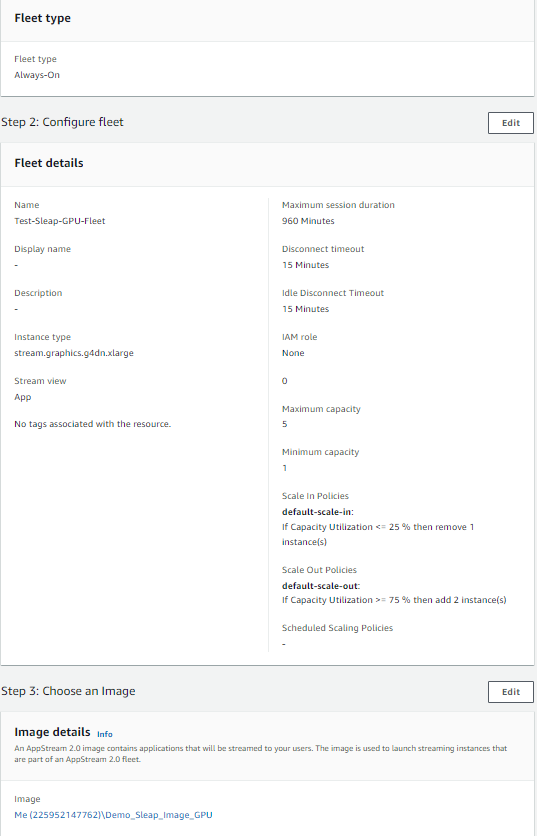

**2. Create stack**

Create a stack and associate it with the fleet. For this demo, we disabled Home Folder and Application Settings Persistence since these features require creating an S3 bucket to store user settings. 

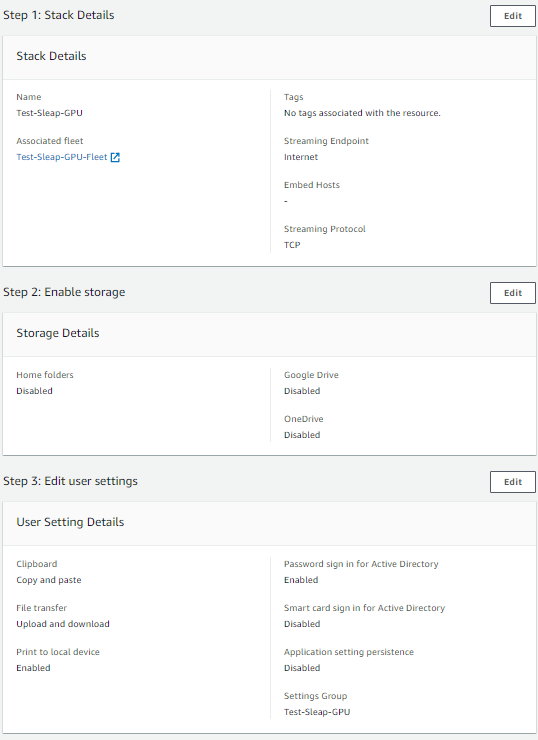

## Test App 

For quick testing, create temporary streaming URLs from the stack. Since App view is chosen for this demo, the user will only see the App's window against a black backgroudn. If the Desktop view was chosen, the user will see the App's window against a standard dekstop. filling up the display. For testing, we verified that the user can activate the sleap environment and launch the Sleap GUI successfully in this instance, then end the session. For more permanent user access options, see [the section on user access](#Provide-user-access-to-AppStream).

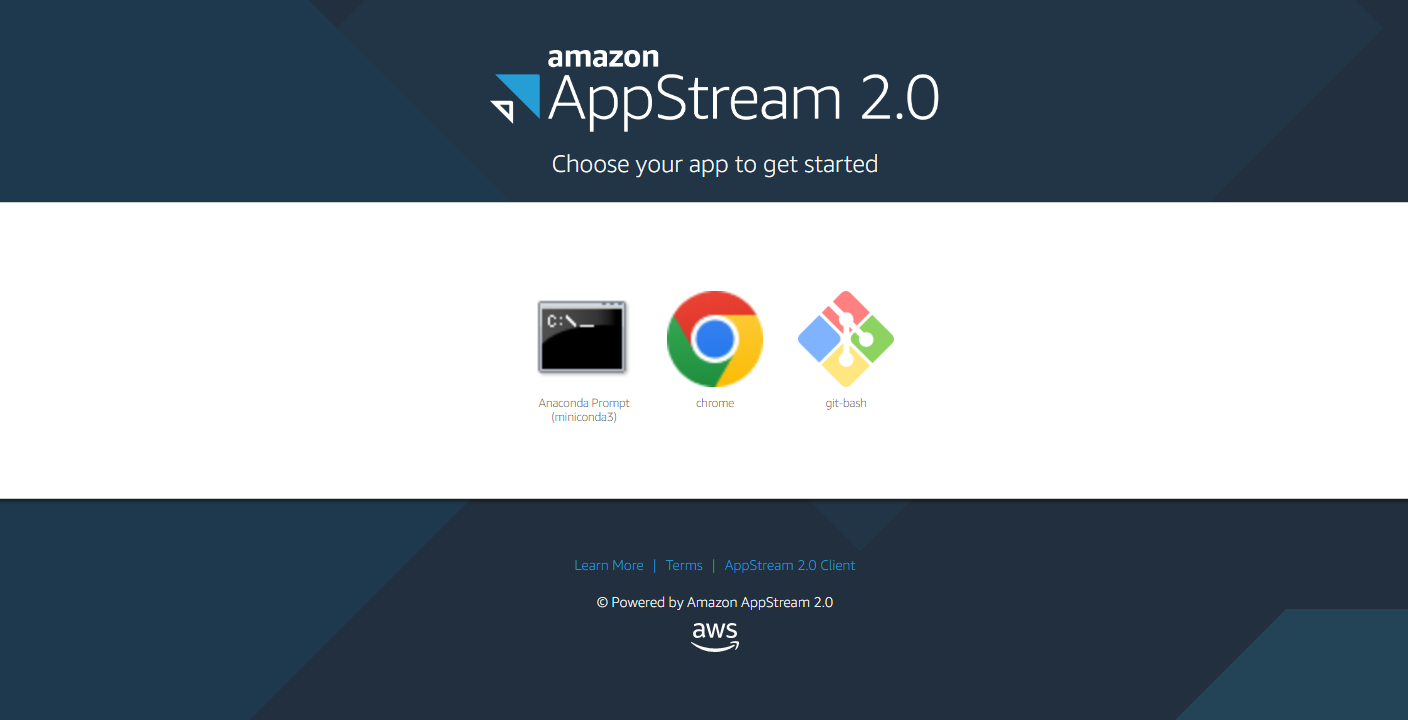

## Provide user access to Appstream

AppStream provides a built-in way of providing user access via User Pools. You may also manage users via Active Directory or SAML Federation. There are several solutions that use third-party SAML authentication, and we only explore Okta here as an example. See [here](https://docs.aws.amazon.com/appstream2/latest/developerguide/external-identity-providers-further-info.html) for more ways to integrate with SAML. 

1. **AppStream User Pool**

Manually add each user with their emails, and assign stacks to each user. The user will receive a log-in link and a temporary password. The user will be prompted to pick a new password on the first log-in attempt, but the log-in link will be permanent and so the user should save it somewhere secure. The user will then have access to the apps specified by the stack that was being added to the user. 

**You would have to attach an IAM role with other AWS service permissions to a fleet in order to give users access to those services.**

2. Terraform User Pool

You may use [Terraform](https://registry.terraform.io/providers/hashicorp/aws/latest/docs/resources/appstream_user) to add and manage users via User Pool as well. It is possible to manage many users at once with Terraform commands. 

It is easy to create a fleet, create a stack, and associate them in Terraform. More steps are needed to create fleet autoscaling policies in Terraform than in the Console, since it requires setting up CloudWatch Alarms separately. However, it is much more complicated to automate image building in Terraform, so this option is pushed back for the future. 


3. Okta

It is possible to [setup SAML for Appstream](https://docs.aws.amazon.com/appstream2/latest/developerguide/external-identity-providers-setting-up-saml.html) so that users can log in with existing credentials and stream apps. Specifically, instructions to [integrate Appstream with Okta](https://saml-doc.okta.com/SAML_Docs/How-to-Configure-SAML-2.0-for-Amazon-AppStream-2-0.html) is carefully documented. 

**Okta will be in charged of managing users' permissions to access AWS services such as S3 buckets.**

Steps to setup:

- Add Okta as Identity Provider in AWS. 
- Create Role to establish trust between Okta and Appstream, so users authenticated by Okta can access an AppStream Stack. 
- Configure Okta to add AppStream. P.S. You will need admin access in Okta.

4. *Active Directory User*


## Provide Access to S3 data via IAM role

For this demo, we will provide users access to S3 data by 1) Authenticating Users via AppStream User Pool, and 2) Providing access via Configuring Fleets with IAM role. 

As mentioned in instructions to [Configure Appstream Fleets](https://docs.aws.amazon.com/appstream2/latest/developerguide/set-up-stacks-fleets.html), you can apply an IAM role to an AppStream fleet, so that users can make AWS API requests from the fleet instance without manually managing AWS credentials. In fact, AppStream will create temporary AWS credentials behind the scene to enable users to make those requests. The credentials will be created under the profile name **appstream_machine_role**, so whenever a user launches a fleet instance and wants to access AWS services, they must user this profile name. 

[This page](https://docs.aws.amazon.com/appstream2/latest/developerguide/using-iam-roles-to-grant-permissions-to-applications-scripts-streaming-instances.html#how-to-create-iam-role-to-use-with-streaming-instances) details the instructions of creating an IAM role with the desired S3 permissions. For this demo, a **appstream_data_bucket__role** role was created with limited permissions to read and write an appstream S3 bucket. This role is attached when creating the fleet so that users can access S3 resources. 

There are two primary ways of accessing AWS servies with a profile: AWS CLI, and Python Boto3. Here are some simple examples of how to use them to upload a file to the S3 bucket and list objects in the bucket to confirm it has been uploaded. You would need a `FILE_PATH` that points to the location of the file in the fleet instance and a `BUCKET_NAME` to perform these operations. See [the section on Upload Local Files](##Upload-Local-Files-to-AppStream) for more instructions on how to upload a local file to the fleet instance and obtain the `FILE_PATH`. 

### AWS CLI
    
Since we have already set the environment variable `AWS_PROFILE="appstream_machine_role"` during the image building phase, users can run the following commands in the command line. 

    aws s3 cp FILE_PATH s3://BUCKET_NAME 
    aws s3 ls s3://BUCKET_NAME 

If the environment variable `AWS_PROFILE` was not set, users would have to run the commands with an additional flag. 

    aws s3 cp FILE_PATH s3://BUCKET_NAME --profile appstream_machine_role
    aws s3 ls s3://BUCKET_NAME --profile appstream_machine_role

### Boto3

Boto3 is AWS SDK Client for Python, and it must be installed during the Image Building phase as an Admin user (run `pip install boto3` in Anaconda Command Prompt). Then uers can run the following commands in the command line.


    import boto3
    
    # using client interface
    s3_client = boto3.client('s3')
    s3_client.upload_file(FILE_PATH, BUCKET_NAME, OBJECT_NAME)
    objects = s3_client.list_objects(Bucket=BUCKET_NAME)
    for obj in objects['Contents']:
        print(obj['Key'])
    
    # using resource interface
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(BUCKET_NAME)
    object = bucket.Object(key=OBJECT_NAME).put(Body=open(FILE_PATH, 'rb'))
    for obj in bucket.objects.all():
        print(obj.key)
        
Similarly, if the environment variable `AWS_PROFILE` was not set, users would have to run the following code instead. 

    # using client interface
    session = boto3.Session(profile_name='appstream_machine_role')
    s3_client = session.client('s3')
    # the rest is the same
    
    # using resource interface
    session = boto3.Session(profile_name='appstream_machine_role')
    s3 = session.resource('s3')
    # the rest is the same

## Upload Local Files to AppStream

Note that the Upload action must be enabled when configuring the fleet. When a user is in a fleet instance, they can click on the `My Files` icon on the upper left, and upload files into the Template Folder by dragging them from the local computer or using the `Upload Files` button. The uploaded files will then be stored under the `C:\Users\PhotonUser\My Files\Temporary Files` folder. 

For this demo, a folder `user-name` is created under `Temporary Files` and a video is uploaded to `user-name`. 
Hence `FILE_PATH="Users\PhotonUser\My Files\Temporary Files\louise-xu\centered_pair_small.mp4"`. However, if you would like the users to upload the entire username folder along with the video subfiles, cd to the `My Files` directory and run the following AWS CLI command for recursive upload. 

    aws s3 cp "Temporary Files" s3://BUCKET_NAME --recursive

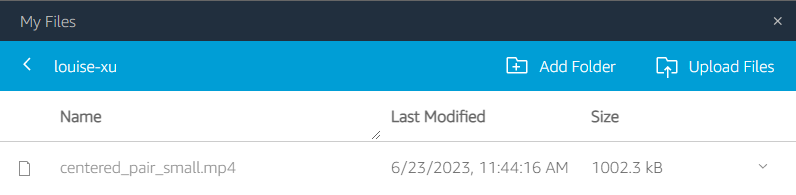

## Provide access to S3 Data via S3FS

S3FS: 

- image building: install s3fs, mount dev bucket onto instance
- Appstream Bucket Name: aind-appstream-data-dev-0tvf3cjlng0m

Install S3FS on Windows: Install [MYSY2](https://www.msys2.org/) up till step 5, then follow the [official install instructions](https://github.com/s3fs-fuse/s3fs-fuse/blob/master/COMPILATION.md) in a MYSY2 console. 

- Skip installing libopenssl-devel (it wasn't available for me)
- When installing WinFSP, remember to choose the option to install the 'Developer' files.
- After tring to make files in step 6 and run `make install`, you may receive an error suggesting a missing line of code. Add that line of code into the designated file and rerun the `make install` command. 

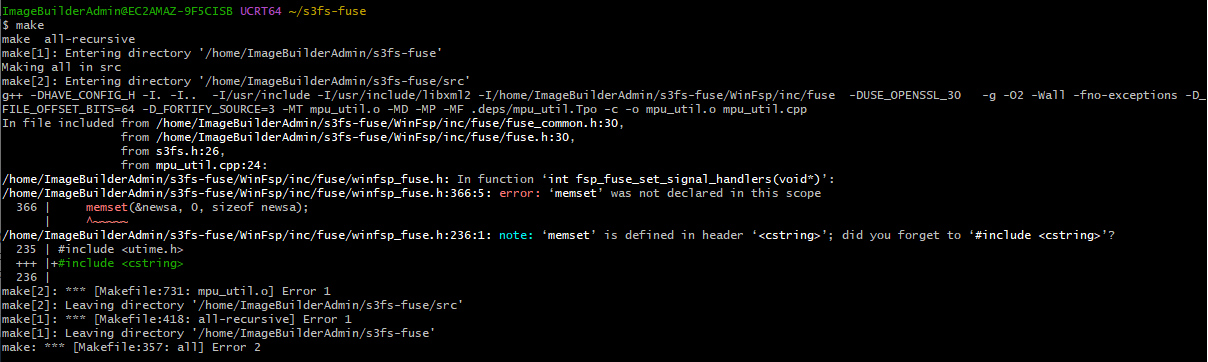

- Move executable file and DLL files into a bin directory as instructed

Now we can copy the contents of the bin directory to whichever directory we would like to have the users run the program in. For this demo, copy the bin directory content to `C:\s3fs\` as an Admin User, so that the contents will still be available to all users. 

**Linux Mount S3 Bucket**   

    aws s3 ls s3://aind-appstream-data-dev-0tvf3cjlng0m
    
    cd $HOME 
    mkdir s3-mount
    
    # Linux user: password file
    vi .passwd-s3fs
    chmod 600 .passwd-s3fs
    s3fs aind-appstream-data-dev-0tvf3cjlng0m  s3-mount \
    -o passwd_file=.passwd-s3fs 
    # successful!
    
    # Linux user: assumed role
    s3fs aind-appstream-data-dev-0tvf3cjlng0m s3-mount \
    -o iam_role="appstream_data_bucket__role" \
    -o url="https://s3-us-west-2.amazonaws.com" \
    -o endpoint=us-west-2 \
    -o dbglevel=info -o curldbg \
    -o allow_other \
    # no erros, but no result

## Linux platform

Need to attach IAM role `appstream_data_bucket__role` to fleet or image builder in order for AppStream to create the AWS profile `appstream_machine_role` which can be used to access the S3 bucket `aind-appstream-data-dev-0tvf3cjlng0m`, either through AWS CLI or through S3FS. 

    # This is the $HOME/.aws/config file created by AppStream
    credential_process = /usr/local/appstream/credentials-provider/AppStreamRoleCredentialProvider --role=Machine

When installing conda with sudo in `/opt/miniconda3`, and run in batch mode with `-b` to skip command line prompts for user interaction. P.S. Without batch mode, it will prompt to run conda init during installing, and you may enter yes, although it will not be useful since it will only modify the `/root/.bashrc` file. You will need to run `conda init` manually later on to create a `$HOME/.bashrc` file in order to activate conda environments in the shell. Similarly, users will need to run `conda init` in the fleet instances to create the .bashrc file in their own home directory. P.P.S. Creating / listing environments don't require conda init, only activating. 


Current status: Mounting via my account credentials (password file) works. Mounting via IAM role (`appstream_data_bucket__role`) doesn't. 

Next steps:

- Conda:
    - Optimal:
        - no conda init during install
        - no chmod for conda.sh
        - conda init
        - sudo conda create -p /opt/miniconda3/test **(check if user can access)**
    - User:
        - conda init
        - *create new terminal window*
        - conda activate test
    - Test-Linux-Withrole:
        - no conda init (no modifies to /root/.bashrc)
        - chmod to conda.sh (works)
        - conda init
        - conda create test
    - Test-CondaSleap: 
        - sudo bash /opt/miniconda3
        - yes to conda init (modifies /root/.bashrc)
        - no chmod to conda.sh
        - conda init
        - conda create test
    
- S3FS: store .passwd file in image

- S3FS: Check whether iam role works
    - try in linux img builder: no
    - try in linux user instance: no
    - check whether iam role has credentials for use
    - verify iam role has permissions for s3 bucket

### Linux install apps

Admin: Download chrome, conda (sleap), s3fs
Default: set AWS_PROFILE=appstream_machine_role

When opening chrome app for the fisrt time, you will be prompted for a key. Leave it blank and just press enter. 

    sudo yum update -y
    
    # install s3fs:
    sudo amazon-linux-extras install epel -y && sudo yum install s3fs-fuse -y
    
    # install chrome:
    sudo yum install chromium.x86_64 -y
    
    # install miniconda:
    wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
    sudo bash Miniconda3-latest-Linux-x86_64.sh -p /opt/miniconda3 -b 
    sudo sh -c "echo $'export PATH="/opt/miniconda3/bin:$PATH"\nexport CONDA_ENVS_PATH="/opt/miniconda3/envs"' >> /etc/profile.d/conda.sh"
    # sudo chmod a+rx /etc/profile.d/conda.sh
    source /etc/profile.d/conda.sh # or open a new terminal window
    
    # install test env
    sudo /opt/miniconda3/bin/conda create -n test python=3.9
    
    # install sleap
    sudo /opt/miniconda3/bin/conda create -n sleap -c sleap -c nvidia -c conda-forge sleap=1.3.0 -y
    conda activate sleap
    
    export AWS_PROFILE="appstream_machine_role" # or do in Image assistance console

### Linux Conda Init

    eval "$(/home/ImageBuilderAdmin/miniconda3/bin/conda shell.bash hook)"
    
    # >>> conda initialize >>>
    # !! Contents within this block are managed by 'conda init' !!
    __conda_setup="$('/home/ImageBuilderAdmin/miniconda3/bin/conda' 'shell.bash' 'hook' 2> /dev/null)"
    if [ $? -eq 0 ]; then
        eval "$__conda_setup"
    else
        if [ -f "/home/ImageBuilderAdmin/miniconda3/etc/profile.d/conda.sh" ]; then
            . "/home/ImageBuilderAdmin/miniconda3/etc/profile.d/conda.sh"
        else
            export PATH="/home/ImageBuilderAdmin/miniconda3/bin:$PATH"
        fi
    fi
    unset __conda_setup
    # <<< conda initialize <<<

### Linux create image
No use of imagebuilder app yet.
 Installed miniconda in imagebuilderadmin, created test conda env. 
 In terminal: 
 
 - create temp/chromium-manifest.txt, add app via CLI, run Chrome and set shortcut and copy config to /etc/skel/profile.d, export AWS_PROFILE
 - create test user, test chrome shortcut, echo AWS_PROFILE
 - create image
 
     vi getfilestool.sh
     chmod u+x ~/getfilestool.sh
     ps -ef | grep chromium
     sudo ~/getfilestool.sh 16712 > /tmp/chromium-manifest.txt
     
     AppStreamImageAssistant add-application \
     --name Chromium \
     --absolute-app-path /usr/lib64/chromium-browser/chromium-browser \
     --display-name Chromium \
     --absolute-icon-path /usr/share/icons/hicolor/256x256/apps/chromium-browser.png \
     --absolute-manifest-path /tmp/chromium-manifest.txt
     
     AppStreamImageAssistant add-application \
     --name GNOME_Terminal \
     --absolute-app-path /usr/bin/gnome-terminal \
     --display-name "Terminal" \
     --absolute-icon-path /usr/share/icons/gnome/256x256/apps/utilities-terminal.png \
     --absolute-manifest-path /tmp/gnome-terminal-manifest.txt
     
     find miniconda3 > tmp/conda-manifest.txt
     AppStreamImageAssistant add-application \
     --name Anaconda_Prompt \
     --absolute-app-path /usr/bin/gnome-terminal \
     --display-name "Anaconda_Prompt" \
     --launch-parameters "source ~/miniconda3/etc/profile.d/conda.sh" \
     --absolute-icon-path /usr/share/icons/gnome/256x256/apps/utilities-terminal.png \
     --absolute-manifest-path /tmp/conda-manifest.txt
     
     AppStreamImageAssistant create-image \
     --name "Demo_Linux_Image_Chrome_Terminal_Conda"
     --description "Apps include Chrome, Terminal, Conda. Install Chrome via yum. Install Conda via Linux installer under ImageBuilderAdmin, created test env. Set AWS_PROFILE."

## *Install DLC*
Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found

conda env create -f DEEPLABCUT.yaml
conda install -c conda-forge cudatoolkit
conda install -c conda-forge cudnn
conda install -c nvidia cuda-nvcc

cd examples
python testscripts.py

qt.qpa.plugin: Could not find the Qt platform plugin "windows" in ""
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.


## Explore other options

Explore the possibility of storing Sleap as an app block (aka a virtual harddisk) in order to create Elastic fleet instances. 

- Always-on fleet: streaming instances are preconfigured with apps, instances run all the time even when no users are streaming, users start streaming immediately after choosing an app / desktop.
- On-Demand fleet: streaming instances are preconfigured with apps, instances only run when users are streaming, users start streaming after 1-2 min wait. 
- Elastic fleet: users select app / desktop to launch and app block has been downloaded and mounted to instance, users start streaming

Enable Persistent Storage (need S3 permissions to view bucket contents)

- User settings will be saved accross sessions, such as user-set environment variables and files saved in Home Folder (Files saved in Temporary folder will not be saved). The settings will be saved in the stack's corresponding S3 bucket under a unique folder for each user (hash of username).  


**Depracated: s3fs folder and .bash_profile under /Users aren't available**

Next, as a Template user, create a directory where all the S3 buckets will be mounted. Also link the s3fs program files to the home directory so it's easier to access. Lastly, create a `.bash_profile` that contains an alias for running the s3fs program. If the user would like to use other consoles such as the Windows command prompt, they may use the path to the `s3fs.exe` file to run the program directly. But if users use Git Bash, they would only need to type the alias `s3fs` in the command line to run the s3fs program. 

    cd $HOME
    ln -s /c/s3fs $HOME/s3fs-user
    touch .bash_profile
    vi .bashrc
    
    # In .bashrc
    alias test='echo "Hello world!"'
    alias s3fscmd='${HOME}/../../s3fs/s3fs.exe'
    alias s3fscmd-user='${HOME}/s3fs-user/s3fs.exe'
    
    # open another git bash window to generate .bash_profile
    

Finally, as a Test user, we are ready to mount an S3 bucket onto the instance. 

    s3fs aind-appstream-data-dev-0tvf3cjlng0m ./s3-mount -o passwd_file=.passwd-s3fs
    df -h

**Blocked: Windows Image**

As a fleet instance user, since the s3fs files are available in the C drive, and mime.types is available at `:C\etc\mime.types`, run the following commands to run s3fs. 

    # Windows conda: iam role
    cd Users\PhotonUser
    ..\..\s3fs\s3fs.exe aind-appstream-data-dev-0tvf3cjlng0m .\s3-mount -o iam-role=appstream_data_bucket__role -o url="https://s3-us-west-2.amazonaws.com" -o endpoint=us-west-2 -o mime=..\..\etc\mime.types -o dbglevel=info -f -o curldbg
    # s3fs: could not determine how to establish security credentials.
    
    # Windows conda: password file
    cd Users\PhotonUser
    ..\..\s3fs\s3fs.exe aind-appstream-data-dev-0tvf3cjlng0m .\s3-mount -o passwd_file=.passwd-s3fs -o mime=..\..\etc\mime.types -o dbglevel=info -f -o curldbg
    # s3fs: credentials file .passwd-s3fs should not have others permissions.
    

    # Windows gitbash: iam role
    cd /c/Users/PhotonUser   
    /c/s3fs/s3fs.exe aind-appstream-data-dev-0tvf3cjlng0m \
    -o mime=/c/etc/mime.types \
    -o iam_role="appstream_data_bucket__role" \
    -o url="https://s3-us-west-2.amazonaws.com" \
    -o endpoint=us-west-2 \
    -o dbglevel=info -o curldbg \
    -o allow_other \
    ./s3-mount
    # s3fs: temporary directory doesn't exists.
    
    # Windows gitbash: password file
    cd /c/Users/PhotonUser   
    /c/s3fs/s3fs.exe aind-appstream-data-dev-0tvf3cjlng0m ./s3-mount \
    -o mime=/c/etc/mime.types \
    -o passwd_file=.passwd-s3fs \
    -o dbglevel=info -o curldbg \
    -o allow_other 
    # s3fs: credentials file .passwd-s3fs should not have others permissions.

Issue: Need to change passwd file permission as admin in windows: not sure how this works
    
    icacls .\.passwd-s3fs 
    icacls .\.passwd-s3fs /inheritance:r /grant:r "NT AUTHORITY\SYSTEM":(N) "BUILTIN\Administrators":(N) "EC2AMAZ-1PVRVIC\ImageBuilderAdmin":(F)